In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid

In [2]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, class_size=10, features=64, out_channels=1):
        super().__init__()
        
        self.embedding = nn.Embedding(class_size, class_size)
        input_dim = noise_dim + class_size        
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=input_dim, out_channels=features, kernel_size=4, stride=1, padding=0, bias=False), # features x 4 x 4
            nn.BatchNorm2d(num_features=features),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(in_channels=features, out_channels=features*2, kernel_size=4, stride=2, padding=1, bias=False), # features*2 x 8 x 8
            nn.BatchNorm2d(num_features=features*2),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(in_channels=features*2, out_channels=features*4, kernel_size=4, stride=2, padding=1, bias=False), # features*4 x 16 x 16
            nn.BatchNorm2d(num_features=features*4),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(in_channels=features*4, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False),  # 1 x 32 x 32
            nn.Tanh(),
            
        )
        
    def forward(self, x, labels):
        x = torch.cat([x, self.embedding(labels)], dim=1)
        
        x = x.view(x.shape[0], x.shape[1], 1, 1)
        
        x = self.model(x)
        
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1,  image_size=32, class_num=10, features=64):
        super().__init__()
        self.image_size = image_size
        self.embedding = nn.Embedding(class_num, image_size*image_size)
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels+1, out_channels=features, kernel_size=4, stride=2, padding=1, bias=False), # features x 16 x 16
            nn.BatchNorm2d(num_features=features),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=features, out_channels=features*2, kernel_size=4, stride=2, padding=1, bias=False), # features*2 x 8 x 8
            nn.BatchNorm2d(num_features=features*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=features*2, out_channels=features*4, kernel_size=4, stride=2, padding=1, bias=False), # features*4 x 4 x 4
            nn.BatchNorm2d(num_features=features*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=features*4, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False), # 1 x 1 x 1
            nn.Sigmoid(),
        )
        
    def forward(self, x, labels):
        x = torch.cat([x, self.embedding(labels).view(labels.shape[0], 1, self.image_size, self.image_size)], dim=1)
        
        x = self.model(x)
        
        return x.view(x.shape[0], -1)

In [4]:
data = datasets.FashionMNIST(root='../FashionMNIST/', transform=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

In [5]:
BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NOISE_DIM = 100
EPOCHS = 50
CLASS_NUM = 10
LR = 2e-4
CRITERION = nn.BCELoss()
CLASS_LIST_DICT = {'T-Shirt':1, 'Trouser':2, 'Pullover':3, 'Dress':4, 'Coat':5, 'Sandal':6, 'Shirt':7, 'Sneaker':8, 'Bag':9, 'Ankle boot':10}
CLASS_LIST = list(CLASS_LIST_DICT.keys())

In [6]:
data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
generator = Generator(noise_dim=NOISE_DIM, class_size=CLASS_NUM, features=64, out_channels=1).to(DEVICE)
discriminator = Discriminator(in_channels=1, image_size=32, class_num=CLASS_NUM, features=64).to(DEVICE)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

In [8]:
def train_generator_batch():
    optimizer_generator.zero_grad()
    
    noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(DEVICE)
    fake_labels = torch.randint(0, CLASS_NUM, (BATCH_SIZE,)).to(DEVICE)
    generated_fakes = generator(noise, fake_labels)
    
    discriminator_on_fakes = discriminator(generated_fakes, fake_labels)
    loss = CRITERION(discriminator_on_fakes, torch.ones_like(discriminator_on_fakes))
    
    loss.backward()
    optimizer_generator.step()

In [9]:
def train_discriminator_batch(real_images, real_labels):
    optimizer_discriminator.zero_grad()
    
    noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(DEVICE)
    fake_labels = torch.randint(0, CLASS_NUM, (BATCH_SIZE,)).to(DEVICE)
    generated_fakes = generator(noise, fake_labels)
    
    discriminator_on_fakes = discriminator(generated_fakes, fake_labels)
    discriminator_on_reals = discriminator(real_images, real_labels)
    
    fake_loss = CRITERION(discriminator_on_fakes, torch.zeros_like(discriminator_on_fakes))
    real_loss = CRITERION(discriminator_on_reals, torch.ones_like(discriminator_on_reals))
    
    loss = (fake_loss + real_loss) / 2
    
    loss.backward()
    optimizer_discriminator.step()

  0%|          | 0/469 [00:00<?, ?it/s]

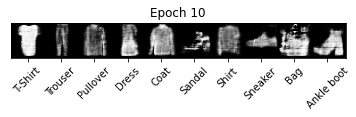

<Figure size 1440x1440 with 0 Axes>

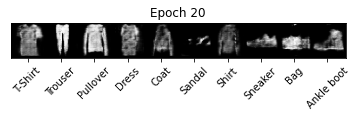

<Figure size 1440x1440 with 0 Axes>

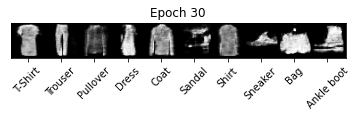

<Figure size 1440x1440 with 0 Axes>

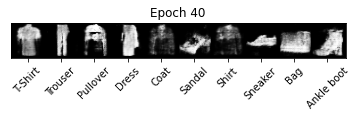

<Figure size 1440x1440 with 0 Axes>

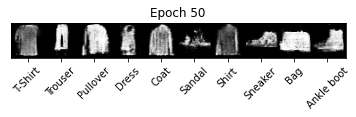

<Figure size 1440x1440 with 0 Axes>

In [10]:
for epoch in range(EPOCHS):
    loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
    
    generator.train()
    discriminator.train()
    
    for batch_index, (real_image, real_label) in loop:
        real_image = real_image.to(DEVICE)
        real_label = real_label.to(DEVICE)
        
        train_discriminator_batch(real_image, real_label)
        train_generator_batch()
        
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        
    generator.eval()
    if (epoch+1) % 10 == 0:
        plt.title(f"Epoch {epoch+1}")
        generated_fakes = generator(torch.randn(CLASS_NUM, NOISE_DIM).to(DEVICE), torch.arange(0, CLASS_NUM).to(DEVICE))
        generated_fakes = make_grid(generated_fakes, nrow=10, normalize=True)
        
        plt.imshow(generated_fakes.permute(1, 2, 0).cpu().detach().numpy())
        _ = plt.xticks([34*i+17 for i in range(10)], CLASS_LIST, rotation=45)
        _ = plt.yticks([])
        _ = plt.figure(figsize=(20, 10))
        plt.show()